# TorchOpt as Meta-Optimizer

[<img align="left" src="https://colab.research.google.com/assets/colab-badge.svg">](https://colab.research.google.com/github/metaopt/torchopt/blob/main/tutorials/3_Meta_Optimizer.ipynb)

In this tutorial, we will show how to treat TorchOpt as a differentiable optimizer with traditional PyTorch optimization API. In addition, we also provide many other API for easy meta-learning algorithm implementations.

## 1. Basic API for Differentiable Optimizer

`MetaOptimizer` is the main class for our differentiable optimizer. Combined with the functional optimizer `torchopt.sgd` and `torchopt.adam` mentioned in the tutorial 1, we can define our high-level API `torchopt.MetaSGD` and `torchopt.MetaAdam`. We will discuss how this combination happens with `torchopt.chain` in Section 3. Let us consider the problem below.

Assume a tensor $x$ is a meta parameter and $a$ is a normal parameters (such as network parameters). We have inner loss $\mathcal{L}^{\textrm{in}} = a_0 \cdot x^2$ and we update $a$ use the gradient $\frac{\partial \mathcal{L}^{\textrm{in}}}{\partial a_0} = x^2$ and $a_1 = a_0 - \eta \, \frac{\partial \mathcal{L}^{\textrm{in}}}{\partial a_0} = a_0 - \eta \, x^2$. Then we compute the outer loss $\mathcal{L}^{\textrm{out}} = a_1 \cdot x^2$. So the gradient of outer loss to $x$ would be:

$$
\begin{split}
        \frac{\partial \mathcal{L}^{\textrm{out}}}{\partial x}
    & = \frac{\partial (a_1 \cdot x^2)}{\partial x} \\
    & = \frac{\partial a_1}{\partial x} \cdot x^2 + a_1 \cdot \frac{\partial (x^2)}{\partial x} \\
    & = \frac{\partial (a_0 - \eta \, x^2)}{\partial x} \cdot x^2 + (a_0 - \eta \, x^2) \cdot 2 x \\
    & = (- \eta \cdot 2 x) \cdot x^2 + (a_0 - \eta \, x^2) \cdot 2 x \\
    & = - 4 \, \eta \, x^3 + 2 \, a_0 \, x
\end{split}
$$

Given the analytical solution above. Let's try to verify it with TorchOpt. Define the net work first.

In [1]:
from IPython.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchopt


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.tensor(1.0), requires_grad=True)

    def forward(self, x):
        return self.a * (x**2)

Then we declare the network (parameterized by `a`) and the meta parameter `x`. Do not forget to set flag `requires_grad=True` for `x`.

In [2]:
net = Net()
x = nn.Parameter(torch.tensor(2.0), requires_grad=True)

Next we declare the meta optimizer. Here we show two equivalent ways of defining the meta optimizer. 

In [3]:
# low-level API
optim = torchopt.MetaOptimizer(net, torchopt.sgd(lr=1.0))

# high level API
optim = torchopt.MetaSGD(net, lr=1.0)

The meta optimizer takes as input the network and use method `step` to update the network (parameterized by `a`). Finally, we show how a bi-level process works.

In [4]:
inner_loss = net(x)
optim.step(inner_loss)

outer_loss = net(x)
outer_loss.backward()
# x.grad = - 4 * lr * x^3 + 2 * a_0 * x
#        = - 4 * 1 * 2^3 + 2 * 1 * 2
#        = -32 + 4
#        = -28
print(f'x.grad = {x.grad!r}')

x.grad = tensor(-28.)


### 1.1 Track the Gradient of Momentum

Note that most modern optimizers involve moment term in the gradient update (basically only SGD with `momentum = 0` does not involve). We provide an option for user to choose whether to also track the meta-gradient through moment term. The default option is `moment_requires_grad=True`.

- When you do not track the meta-gradient through moment (`moment_requires_grad=False`)

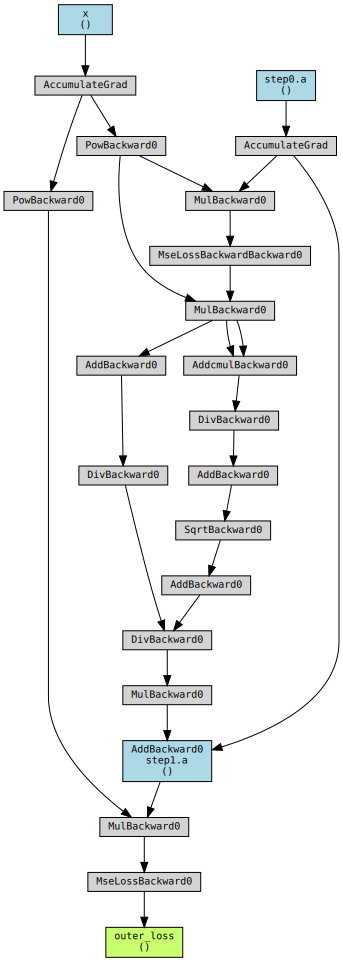

In [5]:
net = Net()
x = nn.Parameter(torch.tensor(2.0), requires_grad=True)
y = torch.tensor(1.0)

optim = torchopt.MetaAdam(net, lr=1.0, moment_requires_grad=False)

net_state_0 = torchopt.extract_state_dict(net, enable_visual=True, visual_prefix='step0.')
inner_loss = F.mse_loss(net(x), y)
optim.step(inner_loss)
net_state_1 = torchopt.extract_state_dict(net, enable_visual=True, visual_prefix='step1.')

outer_loss = F.mse_loss(net(x), y)
display(
    torchopt.visual.make_dot(
        outer_loss, params=[net_state_0, net_state_1, {'x': x, 'outer_loss': outer_loss}]
    )
)

- When you track the meta-gradient through moment (`moment_requires_grad=True`, default for `torchopt.MetaAdam`)

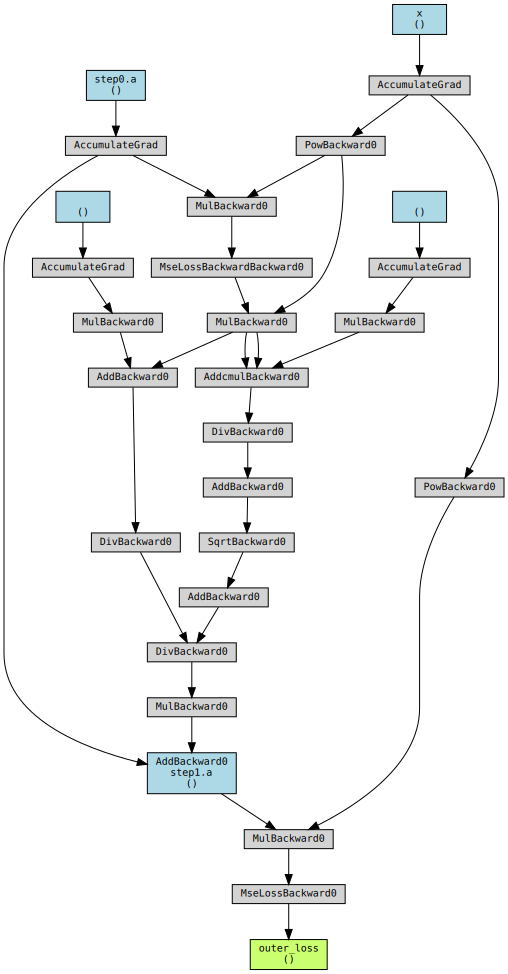

In [6]:
net = Net()
x = nn.Parameter(torch.tensor(2.0), requires_grad=True)
y = torch.tensor(1.0)

optim = torchopt.MetaAdam(net, lr=1.0, moment_requires_grad=True)

net_state_0 = torchopt.extract_state_dict(net, enable_visual=True, visual_prefix='step0.')
inner_loss = F.mse_loss(net(x), y)
optim.step(inner_loss)
net_state_1 = torchopt.extract_state_dict(net, enable_visual=True, visual_prefix='step1.')

outer_loss = F.mse_loss(net(x), y)
display(
    torchopt.visual.make_dot(
        outer_loss, params=[net_state_0, net_state_1, {'x': x, 'outer_loss': outer_loss}]
    )
)

We can see that the additional moment terms are added into the computational graph when we set `moment_requires_grad = True`.

## 2. Extract and Recover

### 2.1 Basic API

We observe that how to reinitialize the inner-loop parameter in a new bi-level process vary in different meta-learning algorithms. For instance, in algorithm like Model-Agnostic Meta-Learning (MAML) ([arXiv:1703.03400](https://arxiv.org/abs/1703.03400)), every time a new task comes, we need to reset the parameters to the initial ones. In other cases such as Meta-Gradient Reinforcement Learning (MGRL) ([arXiv:1805.09801](https://arxiv.org/abs/1805.09801)), the inner-loop network parameter just inherit previous updated parameter to continue the new bi-level process.

We provide the `torchopt.extract_state_dict` and `torchopt.recover_state_dict` functions to extract and restore the state of network and optimizer. By default, the extracted state dictionary is a reference (this design is for accumulating gradient of multi-task batch training, MAML for example). You can also set `copy=True` to extract the copy of state dictionary.

In [7]:
net = Net()
x = nn.Parameter(torch.tensor(2.0), requires_grad=True)

optim = torchopt.MetaAdam(net, lr=1.0)

# Get the reference of state dictionary
init_net_state = torchopt.extract_state_dict(net, by='reference')
init_optim_state = torchopt.extract_state_dict(optim, by='reference')
# If set `detach_buffers=True`, the parameters are referenced as references while buffers are detached copies
init_net_state = torchopt.extract_state_dict(net, by='reference', detach_buffers=True)

# Set `copy` to get the copy of state dictionary
init_net_state_copy = torchopt.extract_state_dict(net, by='copy')
init_optim_state_copy = torchopt.extract_state_dict(optim, by='copy')

# Set `deepcopy` to get the detached copy of state dictionary
init_net_state_deepcopy = torchopt.extract_state_dict(net, by='deepcopy')
init_optim_state_deepcopy = torchopt.extract_state_dict(optim, by='deepcopy')

# Conduct 2 inner-loop optimization
for i in range(2):
    inner_loss = net(x)
    optim.step(inner_loss)

print(f'a = {net.a!r}')

# Recover and reconduct 2 inner-loop optimization
torchopt.recover_state_dict(net, init_net_state)
torchopt.recover_state_dict(optim, init_optim_state)

for i in range(2):
    inner_loss = net(x)
    optim.step(inner_loss)

print(f'a = {net.a!r}')  # the same result

a = tensor(-1.0000, grad_fn=<AddBackward0>)
a = tensor(-1.0000, grad_fn=<AddBackward0>)


### 2.2 Multi-task Example with `extract_state_dict` and `recover_state_dict`

Let's move to another more complex setting. Meta Learning algorithms always fix network on several different tasks and accumulate outer loss of each task to the meta gradient.

Assume $x$ is a meta parameter and $a$ is a normal parameter. We firstly update $a$ use inner loss $\mathcal{L}_1^{\textrm{in}} = a_0 \cdot x^2$ to $a_1$. Then we use $a_1$ to compute the outer loss $\mathcal{L}_1^{\textrm{out}} = a_1 \cdot x^2$ and back-propagate it. Then we use $a_0$ to compute the inner loss $\mathcal{L}_2^{\textrm{in}} = a_0 \cdot x$ and update $a_0$ to $a_2 = a_0 - \eta \, \frac{\partial \mathcal{L}_2^{\textrm{in}}}{\partial a_0} = a_0 - \eta \, x$. Then we compute outer loss $\mathcal{L}_2^{\textrm{out}} = a_2 \cdot x$ and back-propagate it. So the accumulated meta gradient would be:

$$
\begin{split}
        \frac{\partial \mathcal{L}_1^{\textrm{out}}}{\partial x} + \frac{\partial \mathcal{L}_2^{\textrm{out}}}{\partial x}
    & = (- 4 \, \eta \, x^3 + 2 \, a_0 \, x) + \frac{\partial (a_2 \cdot x)}{\partial x} \\
    & = (- 4 \, \eta \, x^3 + 2 \, a_0 \, x) + (\frac{\partial a_2}{\partial x} \cdot x + a_2) \\
    & = (- 4 \, \eta \, x^3 + 2 \, a_0 \, x) + [\frac{\partial (a_0 - \eta \, x)}{\partial x} \cdot x + (a_0 - \eta \, x)] \\
    & = (- 4 \, \eta \, x^3 + 2 \, a_0 \, x) + [(- \eta) \cdot x + (a_0 - \eta \, x)] \\
    & = (- 4 \, \eta \, x^3 + 2 \, a_0 \, x) + (- 2 \, \eta \, x + a_0)
\end{split}
$$

Let's define the network and variables first.

In [8]:
class Net2Tasks(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.tensor(1.0), requires_grad=True)

    def task1(self, x):
        return self.a * x**2

    def task2(self, x):
        return self.a * x


net = Net2Tasks()
x = nn.Parameter(torch.tensor(2.0), requires_grad=True)

optim = torchopt.MetaSGD(net, lr=1.0)

Once we call `step` method of `MetaOptimizer`, the parameters of the network would be changed. We should use `torchopt.extract_state_dict` to extract state and use `torchopt.recover_state_dict` to recover the state. Note that if we use optimizers that have momentum buffers, we should also extract and recover them, vanilla SGD does not have momentum buffers so code `init_optim_state = torchopt.extract_state_dict(optim)` and `torchopt.recover_state_dict(optim, init_optim_state)` have no effect.

In [9]:
# Get the reference of state dictionary
init_net_state = torchopt.extract_state_dict(net, by='reference')
init_optim_state = torchopt.extract_state_dict(optim, by='reference')
# The `state_dict` is empty for vanilla SGD optimizer
print(f'init_optim_state = {init_optim_state!r}')

inner_loss_1 = net.task1(x)
optim.step(inner_loss_1)
outer_loss_1 = net.task1(x)
outer_loss_1.backward()
print(f'Task 1: x.grad = {x.grad!r}')

torchopt.recover_state_dict(net, init_net_state)
torchopt.recover_state_dict(optim, init_optim_state)
inner_loss_2 = net.task2(x)
optim.step(inner_loss_2)
outer_loss_2 = net.task2(x)
outer_loss_2.backward()

# `extract_state_dict`` extracts the reference so gradient accumulates
# x.grad = (- 4 * lr * x^3 + 2 * a_0 * x) + (- 2 * lr * x + a_0)
#        = (- 4 * 1 * 2^3 + 2 * 1 * 2) + (- 2 * 1 * 2 + 1)
#        = -28 - 3
#        = -31
print(f'Accumulated: x.grad = {x.grad!r}')

init_optim_state = ((EmptyState(),),)
Task 1: x.grad = tensor(-28.)
Accumulated: x.grad = tensor(-31.)


## 3. Gradient Transformation in `MetaOptimizer`

We can also use some gradient normalization tricks in our `MetaOptimizer`. In fact `MetaOptimizer` decedents like `MetaSGD` are specializations of `MetaOptimizer`. Specifically, `MetaSGD(net, lr=1.)` is `MetaOptimizer(net, alias.sgd(lr=1., moment_requires_grad=True))`, where flag `moment_requires_grad=True` means the momentums are created with flag `requires_grad=True` so the momentums will also be the part of the computation graph.

In the designing of TorchOpt, we treat these functions as derivations of `combine.chain`. So we can build our own chain like `combine.chain(clip.clip_grad_norm(max_norm=1.), sgd(lr=1., requires_grad=True))` to clip the gradient and update parameters using `sgd`.

$$
\begin{aligned}
        \frac{\partial \mathcal{L}^{\textrm{out}}}{\partial x}
    & = \frac{\partial (a_1 \cdot x^2)}{\partial x} \\
    & = \frac{\partial a_1}{\partial x} \cdot x^2 + a_1 \cdot \frac{\partial (x^2)}{\partial x} \\
    & = \frac{\partial (a_0 - \eta \, g)}{\partial x} \cdot x^2 + (a_0 - \eta \, g) \cdot 2 x                                  & \qquad (g \propto \frac{\partial \mathcal{L}^{\textrm{in}}}{\partial a_0} = x^2, \  {\lVert g \rVert}_2 \le G_{\max}) \\
    & = \frac{\partial (a_0 - \eta \, \beta^{-1} \, x^2)}{\partial x} \cdot x^2 + (a_0 - \eta \, \beta^{-1} \, x^2) \cdot 2 x  & \qquad (g = \beta^{-1} \, x^2, \   \beta > 0, \  {\lVert g \rVert}_2 \le G_{\max}) \\
    & = (- \beta^{-1} \, \eta \cdot 2 x) \cdot x^2 + (a_0 - \beta^{-1} \, \eta \, x^2) \cdot 2 x \\
    & = - 4 \, \beta^{-1} \, \eta \, x^3 + 2 \, a_0 \, x
\end{aligned}
$$

In [10]:
net = Net()
x = nn.Parameter(torch.tensor(2.0), requires_grad=True)

optim_impl = torchopt.combine.chain(
    torchopt.clip.clip_grad_norm(max_norm=2.0),
    torchopt.sgd(lr=1.0, moment_requires_grad=True),
)
optim = torchopt.MetaOptimizer(net, optim_impl)

inner_loss = net(x)
optim.step(inner_loss)

outer_loss = net(x)
outer_loss.backward()
# Since `max_norm` is 2 and the gradient is x^2, so the scale = x^2 / 2 = 2^2 / 2 = 2
# x.grad = - 4 * lr * x^3 / scale + 2 * a_0 * x
#        = - 4 * 1 * 2^3 / 2 + 2 * 1 * 2
#        = -16 + 4
#        = -12
print(f'x.grad = {x.grad!r}')

x.grad = tensor(-12.0000)


## 4. Learning rate scheduler
TorchOpt also provides implementation of learning rate scheduler, which can be used as:

In [16]:
functional_adam = torchopt.adam(
    lr=torchopt.schedule.linear_schedule(
        init_value=1e-3, end_value=1e-4, transition_steps=10000, transition_begin=2000
    )
)

adam = torchopt.Adam(
    net.parameters(),
    lr=torchopt.schedule.linear_schedule(
        init_value=1e-3, end_value=1e-4, transition_steps=10000, transition_begin=2000
    ),
)

meta_adam = torchopt.MetaAdam(
    net,
    lr=torchopt.schedule.linear_schedule(
        init_value=1e-3, end_value=1e-4, transition_steps=10000, transition_begin=2000
    ),
)

## 5. Accelerated Optimizer

Users can use accelerated optimizer by setting the `use_accelerated_op` as `True`. Currently we only support the Adam optimizer.

Check whether the `accelerated_op` is available:

In [10]:
torchopt.accelerated_op_available(torch.device('cpu'))

True


In [11]:
torchopt.accelerated_op_available(torch.device('cuda'))

True


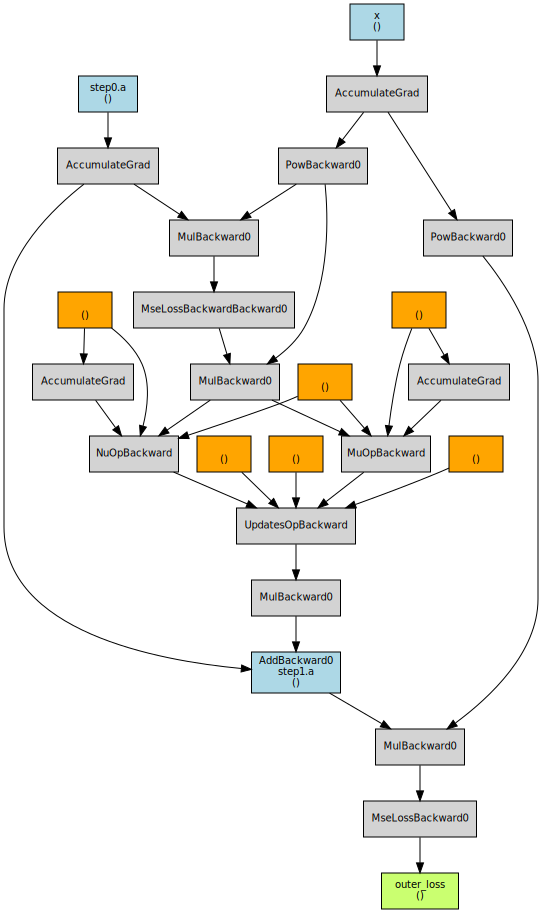

In [12]:
net = Net().to(device='cuda')
x = nn.Parameter(torch.tensor(2.0, device=torch.device('cuda')), requires_grad=True)
y = torch.tensor(1.0, device=torch.device('cuda'))

optim = torchopt.MetaAdam(net, lr=1.0, moment_requires_grad=True, use_accelerated_op=True)

net_state_0 = torchopt.extract_state_dict(
    net, by='reference', enable_visual=True, visual_prefix='step0.'
)
inner_loss = F.mse_loss(net(x), y)
optim.step(inner_loss)
net_state_1 = torchopt.extract_state_dict(
    net, by='reference', enable_visual=True, visual_prefix='step1.'
)

outer_loss = F.mse_loss(net(x), y)
display(
    torchopt.visual.make_dot(
        outer_loss, params=[net_state_0, net_state_1, {'x': x, 'outer_loss': outer_loss}]
    )
)

## 6. Known Issues

Here we record some common issues faced by users when using the meta optimizer.

**1. Get NaN error when using MetaAdam or other optimizers.**

The nan error is because of the numerical instability of the Adam in meta-learning. There exist an sqrt operation in Adam's computation process. Backpropogating through the Adam operator introduces the second derivation of the sqrt operation, which is not numerical stable, i.e. $\frac{d^2 sqrt(x)}{dx^2}|_{x=0}=\text{NaN}$. You can also refer to https://github.com/facebookresearch/higher/issues/125.

For this problem, TorchOpt have two recommended solutions.

* Put the sqrt operation into the whole equation, and compute the derivation of the output to the input manually. The second derivation of the sqrt operation will be eliminated. You can achieve this by setting the flag use_accelerated_op=True, you can follow the instructions in Functional Optimizer and Meta Optimizer.

In [11]:
inner_optim = torchopt.MetaAdam(net, lr=1.0, use_accelerated_op=True)

* Register hook to the first-order gradients. During the back-propagation, the NaN gradients will be set to 0, which will have a similar effect to the first solution but much slower. 

In [12]:
impl = torchopt.chain(torchopt.hook.register_hook(torchopt.hook.zero_nan_hook), torchopt.adam(1e-1))
inner_optim = torchopt.MetaOptimizer(net, impl)

**2. Get `Trying to backward through the graph a second time` error when conducting multiple meta-optimization.**

Refer to the tutorial notebook Stop_gradient for more gudiances.